# Apartments

## Dane

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\01121832\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('../apartments.csv')
data_test = pd.read_csv('../apartments_test.csv')

In [3]:
data.head()

m2.price  construction.year  surface  floor  no.rooms     district
0      5897               1953       25      3         1  Srodmiescie
1      1818               1992      143      9         5      Bielany
2      3643               1937       56      1         2        Praga
3      3517               1995       93      7         3       Ochota
4      3013               1992      144      6         5      Mokotow

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [5]:
data.describe()

m2.price  construction.year      surface        floor     no.rooms
count  1000.000000        1000.000000  1000.000000  1000.000000  1000.000000
mean   3487.019000        1964.823000    85.590000     5.623000     3.360000
std     906.691651          25.831511    37.874799     2.899876     1.381415
min    1607.000000        1920.000000    20.000000     1.000000     1.000000
25%    2857.000000        1943.000000    53.000000     3.000000     2.000000
50%    3386.000000        1965.000000    85.500000     6.000000     3.000000
75%    4018.250000        1988.000000   118.000000     8.000000     4.000000
max    6595.000000        2010.000000   150.000000    10.000000     6.000000

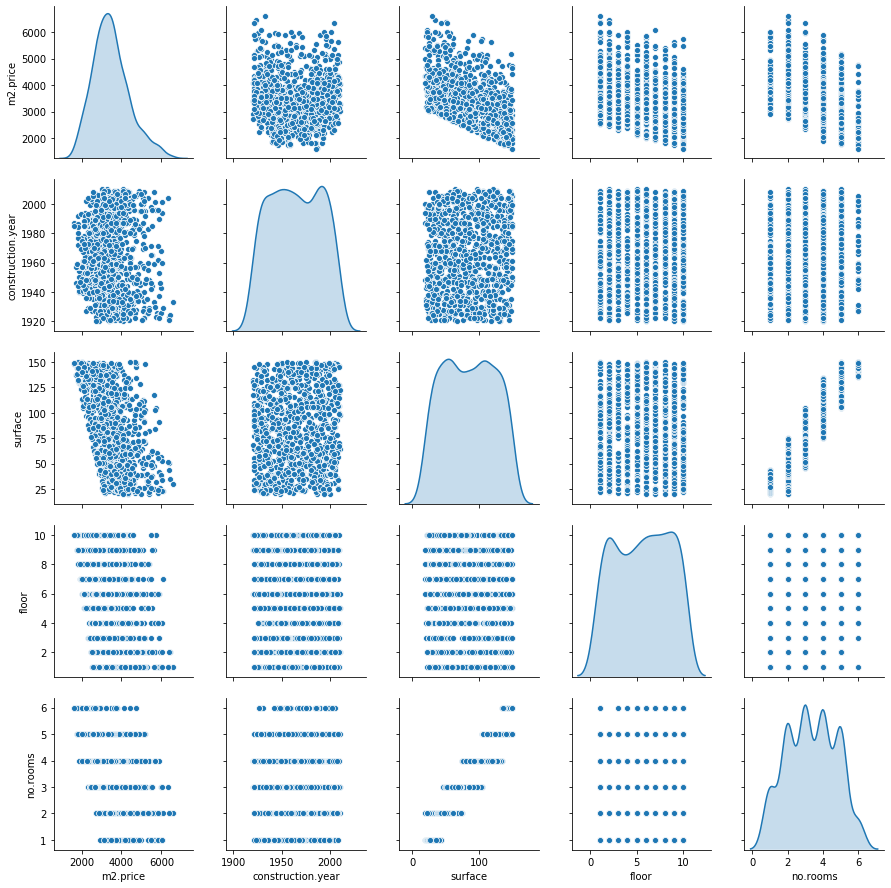

In [6]:
sns.pairplot(data, diag_kind='kde')

Text(0.5, 1, 'Korelacja zmiennych')

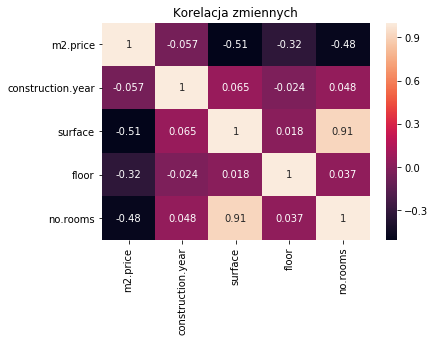

In [7]:
corr=data.corr()
ax=sns.heatmap(corr,
              xticklabels=corr.columns,
              yticklabels=corr.columns, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Korelacja zmiennych')

Od razu widać oczywistą korelację ilości pomieszczeń i powierzchni mieszkania.
Widać, że mało istotne jest ile lat ma mieszkanie.
Ciekawy jest fakt, że im większa powierzchnia, wyższe piętro i więcej pokoi tym tańsze jest mieszkanie.
Najprawdopodobniej wynika to z faktu, że w korelacjach nie uwzględanimy dzielnic. Nie jest zaskakujące, że mieszkania w centrum będą najdroższe nawet pomimo mniejszego metrażu.

## Przygotowanie danych

Braków nie ma, wystarczy zakodować zmienne kategoryczne.

In [8]:
import category_encoders as ce

In [9]:
data['district'].unique()

array(['Srodmiescie', 'Bielany', 'Praga', 'Ochota', 'Mokotow', 'Ursus',
       'Zoliborz', 'Wola', 'Bemowo', 'Ursynow'], dtype=object)

10 dzielnic, spokojnie można objąć One Hot encodingiem. Liczba kolumn wzrośnie nam jedynie do 15, a wierszy mamy tylko 1000 więc powinno to działać relatywnie szybko.

In [10]:
ohe = ce.OneHotEncoder(cols=['district'], use_cat_names=True)
ohe.fit(data)
data = ohe.transform(data)

In [11]:
data_test = ohe.transform(data_test)

In [12]:
X_train = data.drop('m2.price', axis = 1)
y_train = data['m2.price']
X_test = data_test.drop('m2.price', axis = 1)
y_test = data_test['m2.price']

## Model i uczenie bez strojenia

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [51]:
clf = SVR()
clf.fit(X_train, y_train)
mean_squared_error(y_test, clf.predict(X_test))

825769.4375092317

beznadziejnie to chyba mało powiedziane :)

## Strojenie random search

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [53]:
kernel=['rbf'] # jądro gaussowskie
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma = [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9, 1, 5, 10]
param_grid = dict(kernel=kernel, C = C, gamma = gamma)

In [54]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
random = RandomizedSearchCV(estimator=SVR(epsilon = 0.01), param_distributions=param_grid, cv = 4, n_jobs=-1, scoring = scorer)

In [59]:
random_result = random.fit(X_train, y_train)

In [61]:
print("Wyniki na zbiorze treningowym:")
means = random_result.cv_results_['mean_test_score']
for mean, params in zip(means, random_result.cv_results_['params']):
    print("%0.3f dla %r"% (mean, params))

Wyniki na zbiorze treningowym:
-806217.028 dla {'kernel': 'rbf', 'gamma': 0.5, 'C': 10000}
-822322.458 dla {'kernel': 'rbf', 'gamma': 5, 'C': 10000}
-823212.254 dla {'kernel': 'rbf', 'gamma': 0.9, 'C': 1000}
-577840.037 dla {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
-832437.104 dla {'kernel': 'rbf', 'gamma': 1, 'C': 0.01}
-832432.092 dla {'kernel': 'rbf', 'gamma': 0.9, 'C': 1}
-811582.756 dla {'kernel': 'rbf', 'gamma': 0.6, 'C': 10000}
-827601.680 dla {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.1}
-624084.983 dla {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}
-832360.982 dla {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.01}


Najlepsze wyniki dla **gamma: 0.01** **C: 100**

## Dostosowanie modelu

In [63]:
clf = SVR(kernel = 'rbf', gamma = 0.01, C = 100)
clf.fit(X_train, y_train)
mean_squared_error(y_test, clf.predict(X_test))

609437.1205809213

Od razu lepiej